# Analysis pipeline 

In [1]:
#| default_exp 56-analysis-pipeline

In [2]:
%load_ext autoreload
%autoreload 2

from nbdev.showdoc import *
import nbdev; nbdev.nbdev_export()

In [89]:
#| export
import os,torch, torch.multiprocessing as mp, pickle, numpy as np, re
from typing import Optional, Dict, List, Tuple
from torch.utils.data import Dataset
from scipy import sparse
import matplotlib.pyplot as plt

from fastcore.dispatch import *

from xcai.basics import *
from xcai.data import *

import xclib.utils.sparse as xc_sparse
import xclib.evaluation.xc_metrics as xc_metrics
import xclib.data.data_utils as du 

In [6]:
#| export
os.environ['WANDB_MODE'] = 'disabled'

## Load

In [59]:
def load_pred(fname):
    o = np.load(fname)
    return sparse.csr_matrix((o['data'], o['indices'], o['indptr']), dtype=float, shape=o['shape'])


In [11]:
def get_pred_file(dirname):
    output_dir = f"/home/aiscuser/scratch/Projects/xc_nlg/outputs/{dirname}"
    mname = f'{output_dir}/{os.path.basename(get_best_model(output_dir))}'
    pname = f'{mname}/predictions/test_predictions.pkl'
    return pname

def get_output(dirname, n_lbl, pred_type='repr_output'):
    pname = get_pred_file(dirname)
    with open(pname, 'rb') as f: out = pickle.load(f)
    preds,targ = get_output_sparse(**getattr(out,pred_type), n_lbl=n_lbl)
    return preds, targ

def get_pred(dirname, n_lbl):
    pname = get_pred_file(dirname)
    with open(pname, 'rb') as f: out = pickle.load(f)
    pred_ptr = torch.concat([torch.zeros((1,), dtype=torch.long), out.pred_ptr.cumsum(dim=0)])
    return sparse.csr_matrix((out.pred_score, out.pred_idx, pred_ptr), shape=(len(out.pred_ptr), n_lbl))


In [144]:
data_dir = '/home/aiscuser/scratch/datasets'
#pkl_file = f'{data_dir}/processed/wikiseealso_data_distilbert-base-uncased_xcnlg_ngame.pkl'
pkl_file = f'{data_dir}/processed/wikiseealso_data-metas_distilbert-base-uncased_xcnlg_radga.pkl'

with open(pkl_file, 'rb') as file: block = pickle.load(file)

In [12]:
ngame_preds = get_pred('43-encoder-parallel-ngame-for-wikiseealso-1-0', block.n_lbl)

In [14]:
clover_preds,targ = get_output('44-encoder-parallel-clover-for-wikiseealso-1-0', n_lbl=block.n_lbl)

In [45]:
files = {}

In [46]:
data_dir = '/home/aiscuser/scratch/Projects/XC-NLG/models'

In [47]:
file = f"{data_dir}/distilbert-base-uncased_RB33-NAR-1+8-2_(mapped)LF-WikiSeeAlsoTitles-320K/checkpoint-168000/\
predictions/tst_distilbert-base-uncased_RB33-NAR-1+8-2_(mapped)LF-WikiSeeAlsoTitles-320K_nbeams-010-010.txt"
files['NLG-1'] = file

file = f"{data_dir}/distilbert-base-uncased_RB33-NAR-3+8-2_(mapped)LF-WikiSeeAlsoTitles-320K/checkpoint-190000/\
predictions/tst_distilbert-base-uncased_RB33-NAR-3+8-2_(mapped)LF-WikiSeeAlsoTitles-320K_nbeams-010-010.txt"
files['NLG-3'] = file

In [55]:
data_dir = '/home/aiscuser/scratch/Projects/XC'

In [56]:
file = f'{data_dir}/results/NGAME/STransformer/(mapped)LF-WikiSeeAlsoTitles-320K/v_2_100/tst_predictions_knn.npz'
files['NGAME-1'] = file
file = f'{data_dir}/results/NGAME/STransformer/(mapped)LF-WikiSeeAlsoTitles-320K/v_3_100/tst_predictions_knn.npz'
files['NGAME-3'] = file

In [70]:
preds = {k: du.read_sparse_file(v) if v.endswith('.txt') else load_pred(v)  for k,v in files.items()}

## Decile

In [64]:
def pointwise_eval(pred_lbl:sparse.csr_matrix, data_lbl:sparse.csr_matrix, data_lbl_filterer:Optional[np.ndarray]=None,
                   topk:Optional[int]=5, metric:Optional[str]='P', return_type:Optional[str]='M'):
    
    if data_lbl_filterer is not None:
        pred_lbl = Filterer.apply(pred_lbl, data_lbl_filterer)
        data_lbl = Filterer.apply(data_lbl, data_lbl_filterer)
        
    pred_lbl = xc_sparse.retain_topk(pred_lbl, k=topk)
        
    scores = pred_lbl.multiply(data_lbl)
    scores.data[:] = 1
        
    if metric == 'P':
        scores = scores.multiply(1/(topk * data_lbl.shape[0]))
    elif metric == 'R':
        d = data_lbl.getnnz(axis=1) * data_lbl.shape[0]
        scores = scores.multiply(1/d.reshape(-1,1))
    elif metric == 'FN':
        scores = data_lbl - scores
        scores.eliminate_zeros()
        lbl_cnt = data_lbl.getnnz(axis=0)
        scores = scores.multiply(1/(lbl_cnt * data_lbl.shape[1]))

    if return_type == 'M': return scores
    elif return_type == 'L': return np.ravel(scores.sum(axis=0))
    else: return np.ravel(scores.sum(axis=1))
    

In [65]:
def equal_volume_split(data_lbl:sparse.csr_matrix, n_split:int):
    lbl_cnt = data_lbl.getnnz(axis=0)
    lbl_idx = np.argsort(-lbl_cnt)
    thresh = lbl_cnt.sum()/n_split
    
    splits,split,cnt = [],[],0
    for idx in lbl_idx:
        cnt += lbl_cnt[idx]
        split.append(idx)

        if cnt > thresh: 
            splits.append(split)
            split,cnt = [],0

    if len(split): splits.append(split)
    
    if len(splits) != n_split: raise ValueError(f'Number of splits created less than {n_split}.')
    splits.append(lbl_idx.tolist())
    
    lbl_cnt = lbl_cnt.astype(np.float32)
    lbl_cnt[lbl_cnt == 0] = np.nan
    info = [f'{i+1}\n{len(split)//1000}K\n{np.nanmean(lbl_cnt[split]):.2f}' for i,split in enumerate(splits)]
    return splits,info
    

In [66]:
def get_decile_stats(pred_lbl:sparse.csr_matrix, data_lbl:sparse.csr_matrix, data_lbl_filterer:np.ndarray, 
                     n_split:Optional[int]=5, topk:Optional[int]=5, metric:Optional[str]='P'):
    
    evals = pointwise_eval(pred_lbl, data_lbl, data_lbl_filterer, topk=topk, metric=metric)
    splits, info = equal_volume_split(data_lbl, n_split)
    values = [evals[:, split].sum()*100 for split in splits]
    return info, values


In [67]:
def barplot(scores:Dict, title:Optional[str]='', ylabel:Optional[str]='', figsize:Optional[Tuple]=(15,10)):
    n_proc,n_split = len(scores),len(list(scores.values())[0][0])
    idx, width = np.arange(n_split), 0.8/n_proc
    
    fig, ax = plt.subplots(figsize=figsize)

    shift = 0
    for proc,(info,values) in scores.items(): 
        x = idx + shift
        ax.bar(x=x, height=values, width=width, alpha=1, label=proc)
        shift += width

    shift = (n_proc//2)*width if n_proc%2 else width/2 + ((n_proc-1)//2)*width

    ax.set_title(title, fontsize=22)

    ax.set_xlabel('Quantiles \n (Increasing Freq.)', fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)

    ax.set_xticks(idx + shift, info, fontsize=14)
    for o in ax.get_yticklabels(): o.set_fontsize(14)

    ax.legend(fontsize=14)
    

In [68]:
def decile_plot(preds:Dict, n_split:Optional[int]=5, topk:Optional[int]=5, metric:Optional[str]='P', 
                figsize:Optional[Tuple]=(15,10), title:Optional[str]=''):
    scores = {}

    for method, pred in preds.items():
        info, values = get_decile_stats(pred, block.test.dset.data.data_lbl, block.test.data_lbl_filterer, 
                                        n_split=5, topk=5, metric='P')
        scores[method] = (info,values)
    
    barplot(scores, title, f'{metric}@{topk}', figsize)
    

In [71]:
kwargs = {'n_split':5, 'topk':5, 'metric':'P', 'figsize':(15,10),'title': ''}

/opt/conda/envs/ptca/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


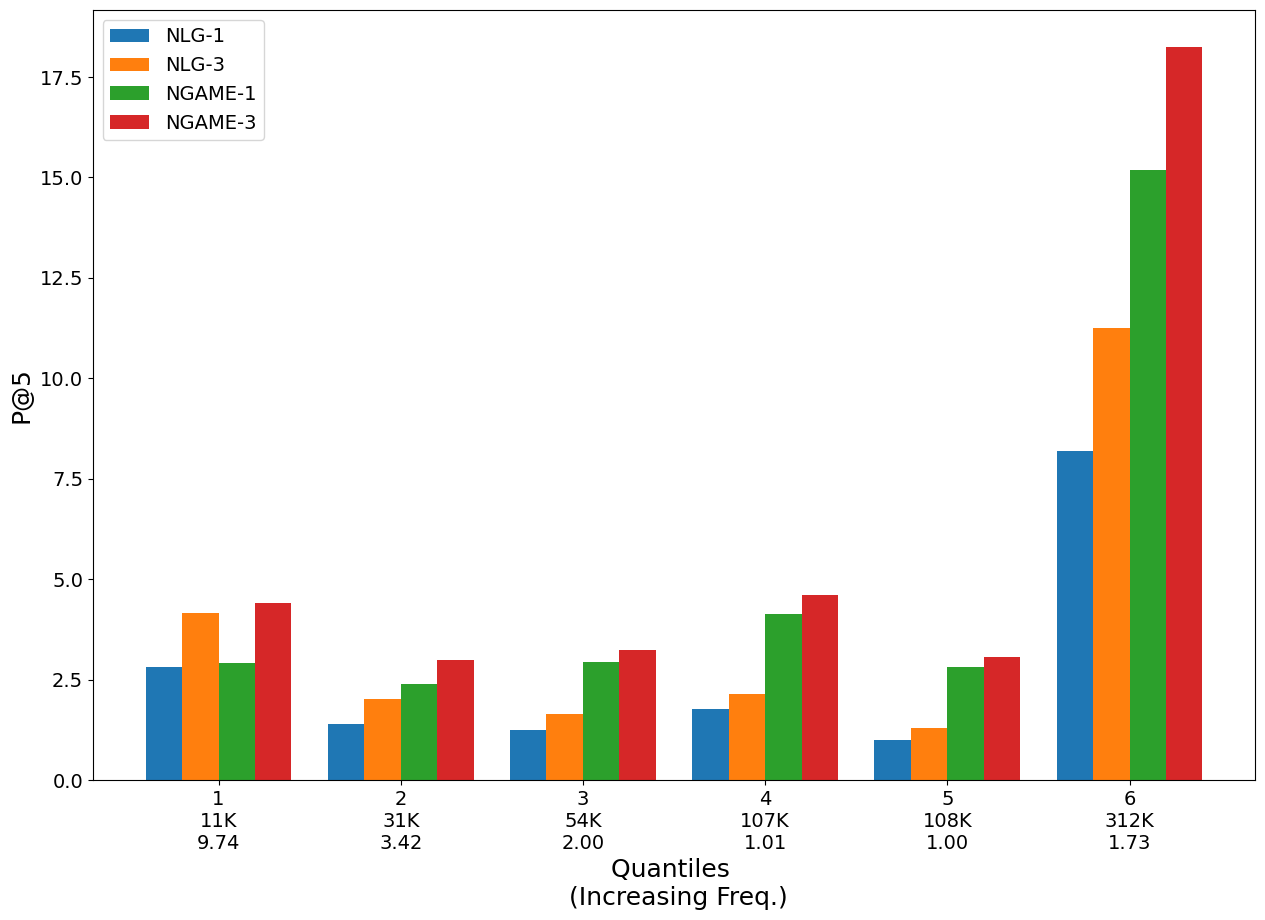

In [72]:
decile_plot(preds, **kwargs)

## Examples

In [73]:
from IPython.display import HTML

In [74]:
def html(text:str, c='green'): return f'<text style=color:{c}>{text}</text>'

In [75]:
def get_pred_dset(pred:sparse.csr_matrix, block:XCDataBlock):
    data = MainXCDataset(block.test.dset.data.data_info, pred, block.test.dset.data.lbl_info, 
                         block.test.dset.data.data_lbl_filterer)
    return XCDataset(data, **block.test.dset.meta)


In [76]:
class TextColumns(Dataset):
    
    def __init__(self, x):
        self.x = x
    
    def __getitem__(self, idx):
        o = self.x[idx]
        return {k:v for k,v in o.items() if re.match('.*_text$', k)}
    

In [90]:
@typedispatch
def display_text(pred_dset:Dataset, data_dset:Dataset, idxs:List):
    color = [('red','green'), ('black','blue')]
    text = []
    for i,idx in enumerate(idxs):
        c = color[i%len(color)]
        pred_text = "<br>".join([f'{html(k,color[0][0])}: {html(v,color[0][1])}' for k,v in pred_dset[idx].items()])
        data_text = "<br>".join([f'{html(k,color[1][0])}: {html(v,color[1][1])}' for k,v in test_dset[idx].items()])
        text.append("<br>".join([pred_text,data_text]))
    return "<br><br>".join(text)

@typedispatch
def display_text(pred1_dset:Dataset, pred2_dset:Dataset, data_dset:Dataset, idxs:List):
    color = [('red','green'), ('black','blue'), ('orange', 'brown')]
    text = []
    for i,idx in enumerate(idxs):
        c = color[i%len(color)]
        pred1_text = "<br>".join([f'{html(k,color[0][0])}: {html(v,color[0][1])}' for k,v in pred1_dset[idx].items()])
        pred2_text = "<br>".join([f'{html(k,color[1][0])}: {html(v,color[1][1])}' for k,v in pred2_dset[idx].items()])
        data_text = "<br>".join([f'{html(k,color[2][0])}: {html(v,color[2][1])}' for k,v in test_dset[idx].items()])
        text.append("<br>".join([pred1_text,pred2_text,data_text]))
    return "<br><br>".join(text)
    

In [91]:
evals = {k: pointwise_eval(v, block.test.dset.data.data_lbl, topk=5, metric='P', return_type='D') for k,v in preds.items()}

In [151]:
top_pred = xc_sparse.retain_topk(preds['NGAME-3'], k=10)
pred1_dset = TextColumns(get_pred_dset(top_pred, block))

top_pred = xc_sparse.retain_topk(preds['NLG-3'], k=10)
pred2_dset = TextColumns(get_pred_dset(top_pred, block))

test_dset = TextColumns(block.test.dset)

In [152]:
idxs = np.argsort(-evals['NGAME-3']+evals['NLG-3'] )[:10]

In [ ]:
data_input_text: Sura (city)
lbl2data_input_text: ['Fallujah', 'Cities of the ancient Near East', 'Assyrian Church of the East', 'Cities of the Ancient Near East', 'Assyrian homeland', 'cities', 'Assyrian tribes', 'Assyrians in Israel', 'Assyrian Tribes', "Assyrian Church of the East's Holy Synod"]
hlk2data_input_text: ['Syriac language', 'Ptolemy', 'Sherira Gaon', 'Nehardea', 'Torah', 'Iraq', 'Shapur I', 'Nehardea Academy', 'Anbar (town)', 'Natronai ben Hilai', 'Abba Arika', 'Euphrates', 'Hebrew language']
hlk2lbl2data_input_text: [['Fallujah Barrage', 'Al Jazeera', 'Gulf War', 'Saddam Hussein', 'Reporters Without Borders'], [], ['Hermann Gollancz', 'Code of Canons of the Eastern Churches', 'Eastern Aramaic languages', 'Peshitta', 'Canada'], [], ['Iraqi Kurdistan', 'Assyrian Democratic Movement', 'Assyrian Church of the East', 'Assyrian genocide', 'Bartella'], [], [], ['Syriac language', 'Jewish Telegraphic Agency', 'Christianity in Israel', 'Assyrian Church of the East', 'Arameans in Israel'], [], []]
cat2data_input_text: ['Babylonia', 'Jewish Babylonian history', 'Talmud places', 'Babylonian cities', 'Former populated places in Iraq']
cat2lbl2data_input_text: [['Fallujah', 'Cities in Iraq', 'Populated places along the Silk Road', 'District capitals of Iraq', 'Populated places in Al Anbar Governorate'], [], ['Christianity in Iran', 'Christianity in Iraq', 'Religious organizations based in Chicago', 'Eastern Christianity', 'Assyrian-American culture in Illinois'], [], ['Historical regions', 'Divided regions', 'Levant', 'Cultural regions', 'Mesopotamia'], [], [], ['Ethnoreligious groups in Israel', 'Israeli people of Assyrian descent', 'Middle Eastern diaspora in Israel', 'Assyrians in Israel', 'Assyrian ethnic groups'], [], []]

In [153]:
HTML(display_text(pred1_dset, pred2_dset, test_dset, idxs))

In [140]:
idxs = np.argsort(-evals['NLG-3']+evals['NGAME-3'])[:10]

In [141]:
HTML(display_text(pred1_dset, pred2_dset, test_dset, idxs))

In [142]:
idxs = np.argsort(np.abs(evals['NLG-3']-evals['NGAME-3']))[:10]

In [143]:
HTML(display_text(pred1_dset, pred2_dset, test_dset, idxs))